# Limpieza de datos con PySpark: Data Science Job Posting on Glassdoor

Los [datos](https://tajamar365.sharepoint.com/:x:/s/3405-MasterIA2024-2025/ETYTQ0c-i6FLjM8rZ4iT1cgB6ipFAkainM-4V9M8DXsBiA?e=PeMtvh) fueron extraídos (scrapeados) del sitio web de Glassdoor y recoge los salarios de distintos puestos relacionados a Data.

### Resolver los siguientes requerimientos, para cada operación/moficación imprima como van quedadndo los cambios.

1. Cargar los datos y mostrar el esquema o la informacion de las columnas y el tip de dato de cada columna

In [0]:
# Leer el archivo CSV especificando el delimitador como punto y coma y encabezado
df = spark.read.option("header", "true") \
               .option("delimiter", ";") \
               .option("multiline", "true") \
               .option("quote", "\"") \
               .option("escape", "\"") \
               .csv("/FileStore/shared_uploads/ds_jobs.csv")

# Mostrar las primeras filas del DataFrame
df.display

2. Eliminar duplicados

In [0]:
df_no_duplicates = df.dropDuplicates()

df_no_duplicates.display()

3. Decidir que hacer con los datos faltantes 

In [0]:
from pyspark.sql.functions import when, col

# Filtrar el DataFrame para ver solo las filas que contienen al menos un valor NULL
df_nulls = df_no_duplicates.filter(
    sum([col(c).isNull().cast("int") for c in df.columns]) > 0
)

# Mostrar las filas con NULL para verificar que existen
df_nulls.display()  # Aquí se usa display() en lugar de show()

# Filtrar el DataFrame para obtener el registro donde el 'Job Title' contenga 'Data Scientist'
employee_sample = df.filter(
    df['Job Title'].contains('Data Scientist')
).first()

# Inicializar df_filled con el DataFrame original en caso de que no se encuentre el empleado
df_filled = df_no_duplicates

# Comprobar que se ha encontrado al menos un empleado
if employee_sample:
    # Extraer los valores de 'Salary Estimate' y 'Job Description' de ese registro
    salary_estimate_sample = employee_sample['Salary Estimate']
    job_description_sample = employee_sample['Job Description']
    
    # Reemplazar los valores NULL en las columnas correspondientes
    df_filled = df.withColumn(
        'Salary Estimate',
        when(col('Salary Estimate').isNull(), salary_estimate_sample).otherwise(col('Salary Estimate'))
    ).withColumn(
        'Job Description',
        when(col('Job Description').isNull(), job_description_sample).otherwise(col('Job Description'))
    )

# Filtrar el DataFrame para obtener el registro con 'index' igual a 676
df_676 = df_filled.filter(df_filled['index'] == 676)

# Mostrar el registro con 'index' igual a 676 y que tenga "Data Scientist" en el 'Job Title'
df_676.filter(df_676['Job Title'].contains('Data Scientist')).display()  # Aquí también se usa display() en lugar de show()


4. Decidir que hacer con los valores nulos

Lo que hice fue buscar un empleado que tenga el mismo rol en la misma empresa. Luego le aplique el mismo salario y descripcion de trabajo ya que deberia coincidir al ser el mismo puesto en la misma empresa.

5. ¿Cuántos registros tiene el csv?

In [0]:
count = df_filled.count()

print(count)


6. Mostrar los valores únicos de `Job title` 

In [0]:
# Seleccionar la columna "Job Title" y obtener registros únicos
df_unique = df_filled.select("Job Title").distinct()

# Mostrar el DataFrame con los registros únicos de "Job Title"
df_unique.display()

7. Remover la letra `K` de la columna `Salary Estimate` y multiplicar por 1000.

In [0]:
from pyspark.sql.functions import regexp_replace, col, split

# Eliminar la letra 'K' y los símbolos no deseados
df_filled = df_filled.withColumn("salary_range_cleaned", regexp_replace(col("Salary Estimate"), "[^\d-]", ""))

# Separar en dos columnas y manejar correctamente los valores
df_filled = df_filled.withColumn("min_salary", split(col("salary_range_cleaned"), "-").getItem(0).cast("int") * 1000) \
                     .withColumn("max_salary", split(col("salary_range_cleaned"), "-").getItem(1).cast("int") * 1000)

df_filled.display()



8. Mostrar los valores únicos del campo `Salary Estimate`

In [0]:
# Mostrar los valores únicos del campo Salary Estimate 
df_filled.select("Salary Estimate").distinct().display()

9. Eliminar `(Glassdoor est.)` y `(Employer est.)` del campo `Salary Estimate`

In [0]:
from pyspark.sql.functions import regexp_replace

# Reemplaza las cadenas '(Glassdoor est.)' y '(Employer est.)' en la columna 'Salary Estimate'
df_filled = df_filled.withColumn(
    "Salary Estimate",
    regexp_replace("Salary Estimate", r"\s*\(Glassdoor est\.\)|\s*\(Employer est\.\)", "")
)

# Muestra los resultados
df_filled.display()


10. Mostrar de mayor a menor los valores del campo `Salary Estimate`

In [0]:
# Ordenar el DataFrame por 'Salary Estimate' en orden descendente
df_filled_desc = df_filled.orderBy("Salary Estimate", ascending=True)

# Mostrar los resultados
df_filled_desc.display()


11. De la columna `Job Description` quitar los saltos de linea `\n` del texto

In [0]:
from pyspark.sql.functions import regexp_replace

# Eliminar los saltos de línea (\n) de la columna 'Job Description'
df_filled = df_filled.withColumn(
    "Job Description",
    regexp_replace("Job Description", r"\\n", " ")
)

# Verificar el resultado
df_filled.display(truncate=False)


12. De la columna `Rating` muestre los valores unicos.

In [0]:
# Seleccionar la columna 'Rating' y obtener los valores únicos
unique_ratings = df_filled.select("Rating").distinct()

# Mostrar los valores únicos
unique_ratings.display()


13. Del campo `Rating` reemplazar los `-1.0` por `0.0`.

In [0]:
from pyspark.sql.functions import when

# Reemplazar los valores -1.0 por 0.0 en la columna 'Rating'
df_filled = df_filled.withColumn(
    "Rating",
    when(df_filled["Rating"] == -1.0, 0.0).otherwise(df_filled["Rating"])
)

# Verificar el resultado
df_filled.select("Rating").display()


14. Mostrar los valores unicos y ordenar los valores del campo `Company Name`.

In [0]:
# Seleccionar la columna 'Company Name', obtener valores únicos y ordenarlos alfabéticamente
unique_companies = df_filled.select("Company Name").distinct().orderBy("Company Name", ascending=True)

# Mostrar los resultados
unique_companies.display(truncate=False)


15. Quitar todos los caracteres innecesarios que encuentres en el campo `Company Name`. Por ejemplo los saltos de linea `\n`

In [0]:
from pyspark.sql.functions import regexp_replace

# Reemplazar los saltos de línea (\n) y otros caracteres innecesarios en la columna 'Company Name'
df_filled = df_filled.withColumn(
    "Company Name",
    regexp_replace("Company Name", r"\\n|\s+", " ")  # Elimina los saltos de línea y reemplaza múltiples espacios por uno solo
)

# Mostrar los resultados
df_filled.select("Company Name").show(truncate=False)


16. En el campo `Location` convertir esa columna en dos: `City` y `State`. Las ciudades que tengas en `Location` asignar a la columna `City`. Lo mismo para `State`. Luego elimine la columna `Location`.

In [0]:
from pyspark.sql.functions import split

# Dividir la columna 'Location' en 'City' y 'State' usando el espacio como delimitador
df_filled = df_filled.withColumn(
    "City", 
    split(df_filled["Location"], ",")[0]  # La ciudad generalmente está antes de la coma
)

df_filled = df_filled.withColumn(
    "State", 
    split(df_filled["Location"], ",")[1]  # El estado está después de la coma
)

# Eliminar la columna 'Location'
df_filled = df_filled.drop("Location")

# Verificar los resultados
df_filled.select("City", "State").show(truncate=False)


17. Repetir la misma lógica de la pregunta 16 pero para el campo `Headquarters`. En Headquarters dejar solo la ciudad, mientras que para el estado añadirla a una columna nueva ` Headquarter State`.

In [0]:
from pyspark.sql.functions import split

# Dividir la columna 'Headquarters' en 'Headquarter City' y 'Headquarter State'
df_filled = df_filled.withColumn(
    "Headquarter City", 
    split(df_filled["Headquarters"], ",")[0]  # La ciudad generalmente está antes de la coma
)

df_filled = df_filled.withColumn(
    "Headquarter State", 
    split(df_filled["Headquarters"], ",")[1]  # El estado está después de la coma
)

# Eliminar la columna 'Headquarters'
df_filled = df_filled.drop("Headquarters")

# Verificar los resultados
df_filled.select("Headquarter City", "Headquarter State").show(truncate=False)


18. Muestre los valores únicos del campo `Headquarter State` 

In [0]:
# Obtener los valores únicos de la columna 'Headquarter State'
unique_states = df_filled.select("Headquarter State").distinct()

# Mostrar los resultados
unique_states.show(truncate=False)


19. Mostrar valores unicos del campo `Size`.

In [0]:
# Obtener los valores únicos de la columna 'Size'
unique_sizes = df_filled.select("Size").distinct()

# Mostrar los resultados
unique_sizes.show(truncate=False)


20. Quitar 'employee' de los registros del campo `Size`. Elimine tambien otros caracteres basura.

In [0]:
from pyspark.sql.functions import regexp_replace

# Reemplazar solo 'employee', 'unknown' y '-1' en la columna 'Size'
df_filled = df_filled.withColumn(
    "Size",
    regexp_replace(df_filled["Size"], r"(^employee$|^unknown$|^-1$)", "")  # Coincide solo con los valores exactos
)

# Verificar el resultado
df_filled.select("Size").show(truncate=False)


21. Reemplazar la palabra 'to' por '-' en todos los registros del campo `Size`. Reemplazar tambien '-1' por 'Unknown'. 

In [0]:
from pyspark.sql.functions import regexp_replace

# Reemplazar 'to' por '-', y '-1' por 'Unknown' en la columna 'Size'
df_filled = df_filled.withColumn(
    "Size",
    regexp_replace(
        regexp_replace(df_filled["Size"], r"\bto\b", "-"),  # Reemplazar 'to' por '-'
        r"-1", "Unknown"  # Reemplazar '-1' por 'Unknown'
    )
)

# Verificar el resultado
df_filled.select("Size").show(truncate=False)


22. Mostrar el tipo de dato del campo `Type of ownership` y sus registros unicos.

In [0]:
# Mostrar el tipo de dato de la columna 'Type of ownership'
df_filled.printSchema()

# Obtener los valores únicos de la columna 'Type of ownership'
df_filled.select("Type of ownership").distinct().show(truncate=False)


23. Cambiar '-1' por 'Unknown' en todos los registros del campo `Type of ownership`.

In [0]:
from pyspark.sql.functions import regexp_replace

# Reemplazar '-1' por 'Unknown' en la columna 'Type of ownership'
df_filled = df_filled.withColumn(
    "Type of ownership",
    regexp_replace(df_filled["Type of ownership"], r"-1", "Unknown")  # Reemplaza '-1' por 'Unknown'
)

# Verificar el resultado
df_filled.select("Type of ownership").show(truncate=False)


24. Cambiar:  
-  `Company - Public` por `Public Company`  
-  `Company - Private` por `Private Company`  
-  `Private Practice / Firm` por `Private Company`  
-  `Subsidiary or Business Segment` por `Business`  
-  `College / University` por `Education`  
En todos los registros del campo `Type of ownership`.

In [0]:
from pyspark.sql.functions import regexp_replace

# Realizar los reemplazos en la columna 'Type of ownership'
df_filled = df_filled.withColumn(
    "Type of ownership",
    regexp_replace(
        regexp_replace(
            regexp_replace(
                regexp_replace(
                    df_filled["Type of ownership"], 
                    r"Company - Public", "Public Company"
                ),
                r"Company - Private", "Private Company"
            ),
            r"Private Practice / Firm", "Private Company"
        ),
        r"Subsidiary or Business Segment", "Business"
    )
)

# Verificar el resultado
df_filled.select("Type of ownership").show(truncate=False)


25. Mostrar el tipo de dato y los valores unicos del campo `Industry`.

In [0]:
# Mostrar el tipo de dato de la columna 'Industry'
df_filled.printSchema()

# Obtener los valores únicos de la columna 'Industry'
df_filled.select("Industry").distinct().show(truncate=False)


26. En el mismo campo de `Industry` reemplazar '-1' por 'Not Available' y '&' por 'and'.  Vuelva a imprimir los valores unicos en orden alfabético.

In [0]:
from pyspark.sql.functions import regexp_replace

# Reemplazar '-1' por 'Not Available' y '&' por 'and' en la columna 'Industry'
df_filled = df_filled.withColumn(
    "Industry",
    regexp_replace(
        regexp_replace(df_filled["Industry"], r"-1", "Not Available"),  # Reemplazar '-1' por 'Not Available'
        r"&", "and"  # Reemplazar '&' por 'and'
    )
)

# Mostrar los valores únicos de la columna 'Industry' ordenados alfabéticamente
df_filled.select("Industry").distinct().orderBy("Industry").show(truncate=False)


27. Para el campo `Sector`, muestre el tipo de dato y los valores únicos.

In [0]:
# Mostrar el tipo de dato de la columna 'Sector'
df_filled.printSchema()

# Obtener los valores únicos de la columna 'Sector'
df_filled.select("Sector").distinct().show(truncate=False)


28. Aplica la misma lógica de la pregunta 26 pero sobre el campo `Sector`.

In [0]:
from pyspark.sql.functions import regexp_replace

# Reemplazar '-1' por 'Not Available' y '&' por 'and' en la columna 'Sector'
df_filled = df_filled.withColumn(
    "Sector",
    regexp_replace(
        regexp_replace(df_filled["Sector"], r"-1", "Not Available"),  # Reemplazar '-1' por 'Not Available'
        r"&", "and"  # Reemplazar '&' por 'and'
    )
)

# Mostrar los valores únicos de la columna 'Sector' ordenados alfabéticamente
df_filled.select("Sector").distinct().orderBy("Sector").show(truncate=False)


29. Para el campo `Revenue`, muestre el tipo de dato y los valores únicos en orden ascedente.

In [0]:
# Mostrar el tipo de dato de la columna 'Revenue'
df_filled.printSchema()

# Obtener los valores únicos de la columna 'Revenue' y ordenarlos de manera ascendente
df_filled.select("Revenue").distinct().orderBy("Revenue").show(truncate=False)


30. En el campo `Revenue`, cambiar:  
-  `-1` por `N/A`  
-  `Unknown / Non-Applicable` por `N/A`  
-  `Less than $1 million (USD)` por `Less than 1`
-  Quitar `$` y `(USD)`

In [0]:
from pyspark.sql.functions import regexp_replace

# Realizar los reemplazos en la columna 'Revenue'
df_filled = df_filled.withColumn(
    "Revenue",
    regexp_replace(
        regexp_replace(
            regexp_replace(
                regexp_replace(df_filled["Revenue"], r"-1", "N/A"),  # Reemplazar '-1' por 'N/A'
                r"Unknown / Non-Applicable", "N/A"  # Reemplazar 'Unknown / Non-Applicable' por 'N/A'
            ),
            r"Less than \$1 million \(USD\)", "Less than 1"  # Reemplazar 'Less than $1 million (USD)' por 'Less than 1'
        ),
        r"[\$\(USD\)]", ""  # Quitar el símbolo '$' y '(USD)'
    )
)

# Verificar el resultado
df_filled.select("Revenue").show(truncate=False)


31. Borrar el campo `Competitors`.

In [0]:
# Eliminar la columna 'Competitors'
df_filled = df_filled.drop("Competitors")

# Verificar que la columna fue eliminada
df_filled.printSchema()


32. Crear tres columnas: `min_salary` (salario mínimo), `max_salary` (salario maximo) y `avg_salary` (salario promedio) a partir de los datos del campo `Salary Estimate`.

In [0]:
df_filled.display()

33. Mostrar los valores unicos del campo `Founded` y el tipo de dato.

In [0]:
# Mostrar el tipo de dato de la columna 'Founded'
df_filled.printSchema()

# Obtener los valores únicos de la columna 'Founded'
df_filled.select("Founded").distinct().show(truncate=False)


34. Reemplazar '-1' por '2024' en todos los registros del campo `Founded`.

In [0]:
from pyspark.sql.functions import regexp_replace

# Reemplazar '-1' por '2024' en la columna 'Founded'
df_filled = df_filled.withColumn(
    "Founded",
    regexp_replace(df_filled["Founded"], r"-1", "2024")  # Reemplaza '-1' por '2024'
)

# Verificar el resultado
df_filled.select("Founded").show(truncate=False)


35. Crear una nueva columna o campo que se llame `company_age` con los datos que se deducen del campo `Founded`.

In [0]:
from pyspark.sql.functions import col, year, current_date

# Obtener el año actual
current_year = year(current_date())

# Crear una nueva columna 'company_age' restando el año de fundación al año actual
df_filled = df_filled.withColumn(
    "company_age",
    current_year - col("Founded")  # Calcula la edad de la empresa
)

# Verificar el resultado
df_filled.select("Founded", "company_age").show(truncate=False)


36. Crear una columna o campo que se llame: `Job Type` y en cada registro debe ir Senior, Junior o NA según los datos del campo `Job Title`.  
- Cambiar 'sr' o 'senior' o 'lead' o 'principal' por `Senior` en el campo `Job Type`. No olvidar las mayúsculas.
- Cambiar 'jr' o 'jr.' o cualquier otra variante por `Junior`.  
- En cualquier otro caso distinto a los anteriores añadir NA.

In [0]:
from pyspark.sql.functions import col, when

# Crear la nueva columna 'Job Type' con las condiciones especificadas
df_filled = df_filled.withColumn(
    "Job Type",
    when(
        col("Job Title").rlike("(?i)sr|senior|lead|principal"), "Senior"  # Condición para 'Senior'
    ).when(
        col("Job Title").rlike("(?i)jr|jr\\."), "Junior"  # Condición para 'Junior'
    ).otherwise("NA")  # En cualquier otro caso poner 'NA'
)

# Verificar el resultado
df_filled.select("Job Title", "Job Type").show(truncate=False)


37. Muestra los registros únicos del campo `Job Type`. 

In [0]:
# Mostrar los valores únicos de la columna 'Job Type'
df_filled.select("Job Type").distinct().show(truncate=False)


38. Partiendo del campo `Job Description` se extraer todas o las principales skills solicitadas por las empresas, por ejemplo: Python, Spark , Big Data. Cada Skill debe ir en una nueva columna de tipo Binaria ( 0 , 1) o Booleana (True,  False) de modo que cada skill va ser una nueva columna y si esa skill es solicitada por la empresa colocar 1 sino colocar 0. Por ejemplo:  

Por ejemplo:  
| Job Title         | Salary Estimate | Job Description                                 | Rating | Company Name       | Size       | Founded | Type of ownership         | Industry                       | Sector                         | Same State      | company_age | Python | Excel |
|--------------------|-----------------|-------------------------------------------------|--------|--------------------|------------|---------|---------------------------|--------------------------------|--------------------------------|----------------|-------------|--------|-------|
| Sr Data Scientist | 137000-171000   | Description The Senior Data Scientist is resp... | 3.1    | Healthfirst        | 1001-5000  | 1993    | Nonprofit Organization    | Insurance Carriers            | Insurance Carriers            | Same State      | 31          | 0      | 0     |
| Data Scientist    | 137000-171000   | Secure our Nation, Ignite your Future Join th... | 4.2    | ManTech            | 5001-10000 | 1968    | Public Company            | Research and Development      | Research and Development      | Same State      | 56          | 0      | 0     |
| Data Scientist    | 137000-171000   | Overview Analysis Group is one of the larges... | 3.8    | Analysis Group      | 1001-5000  | 1981    | Private Company           | Consulting                    | Consulting                    | Same State      | 43          | 1      | 1     |
| Data Scientist    | 137000-171000   | JOB DESCRIPTION: Do you have a passion for Da... | 3.5    | INFICON            | 501-1000   | 2000    | Public Company            | Electrical and Electronic Manufacturing | Electrical and Electronic Manufacturing | Different State | 24          | 1      | 1     |


In [0]:
from pyspark.sql.functions import col, when

# Lista de habilidades (skills) a detectar en las descripciones de trabajo
skills = ["Python", "Spark", "Big Data", "Excel", "SQL", "Java", "Machine Learning", "R", "Tableau", "Hadoop"]

# Crear las columnas binarias para cada skill
for skill in skills:
    df_filled = df_filled.withColumn(
        skill, 
        when(col("Job Description").rlike(f"(?i){skill}"), 1).otherwise(0)  # Buscar el skill y asignar 1 si lo encuentra
    )

# Verificar las primeras filas con las nuevas columnas de skills
df_filled.select("Job Title", "Job Description", *skills).display(truncate=False)


39. Exportar dataset final a csv

In [0]:
# Especificar la ruta del archivo de salida
output_path = "/ruta/a/guardar/archivo.csv"

# Exportar el DataFrame a un archivo CSV
df_filled.write.option("header", "true").csv(output_path)

# Verificar que el archivo se haya creado
print(f"El archivo CSV ha sido exportado a: {output_path}")


In [0]:
df_filled.display()


index Job Title Salary Estimate Job Description Rating Company Name Size Founded Type of ownership Industry Sector Revenue salary_range_cleaned min_salary max_salary City State Headquarter City Headquarter State avg_salary company_age Job Type Python Spark Big Data Excel SQL Java Machine Learning R Tableau Hadoop 0 Sr Data Scientist $137K-$171K Description

The Senior Data Scientist is responsible for defining, building, and improving statistical models to improve business processes and outcomes in one or more healthcare domains such as Clinical, Enrollment, Claims, and Finance. As part of the broader analytics team, Data Scientist will gather and analyze data to solve and address complex business problems and evaluate scenarios to make predictions on future outcomes and work with the business to communicate and support decision-making. This position requires strong analytical skills and experience in analytic methods including multivariate regressions, hierarchical linear models, regression trees, clustering methods and other complex statistical techniques.

Duties & Responsibilities:

� Develops advanced statistical models to predict, quantify or forecast various operational and performance metrics in multiple healthcare domains
� Investigates, recommends, and initiates acquisition of new data resources from internal and external sources
� Works with multiple teams to support data collection, integration, and retention requirements based on business needs
� Identifies critical and emerging technologies that will support and extend quantitative analytic capabilities
� Collaborates with business subject matter experts to select relevant sources of information
� Develops expertise with multiple machine learning algorithms and data science techniques, such as exploratory data analysis and predictive modeling, graph theory, recommender systems, text analytics and validation
� Develops expertise with Healthfirst datasets, data repositories, and data movement processes
� Assists on projects/requests and may lead specific tasks within the project scope
� Prepares and manipulates data for use in development of statistical models
� Other duties as assigned

Minimum Qualifications:

-Bachelor's Degree

Preferred Qualifications:

- Master�s degree in Computer Science or Statistics
Familiarity with major cloud platforms such as AWS and Azure
Healthcare Industry Experience

Minimum Qualifications:

-Bachelor's Degree

Preferred Qualifications:

- Master�s degree in Computer Science or Statistics
Familiarity with major cloud platforms such as AWS and Azure
Healthcare Industry Experience

WE ARE AN EQUAL OPPORTUNITY EMPLOYER. Applicants and employees are considered for positions and are evaluated without regard to mental or physical disability, race, color, religion, gender, national origin, age, genetic information, military or veteran status, sexual orientation, marital status or any other protected Federal, State/Province or Local status unrelated to the performance of the work involved.

If you have a disability under the Americans with Disability Act or a similar law, and want a reasonable accommodation to assist with your job search or application for employment, please contact us by sending an email to careers@Healthfirst.org or calling 212-519-1798 . In your email please include a description of the accommodation you are requesting and a description of the position for which you are applying. Only reasonable accommodation requests related to applying for a position within Healthfirst Management Services will be reviewed at the e-mail address and phone number supplied. Thank you for considering a career with Healthfirst Management Services.
EEO Law Poster and Supplement

]]> 31 Healthfirst 3.1 1001 - 5000 employees 1993 Nonprofit Organization Insurance Carriers Insurance N/A 137-171 null null New York NY New York NY null 31.0 Senior 0 0 0 0 0 0 1 1 0 0 1 Data Scientist $137K-$171K Secure our Nation, Ignite your Future

Join the top I

40. Extraer todos los insights posibles que sean de valor o utilidad. Cree nuevas columnas, agrupar,  filtrar hacer varios plots que muestren dichos insights que sean de utilidad para una empresa o para un usuario. Elabore conclusiones con los insights encontrados. 

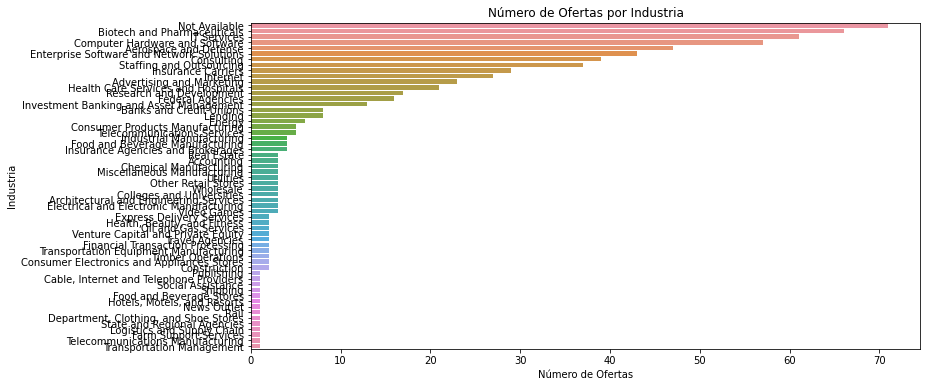

In [0]:
# Agrupar por 'Industry' y contar el número de ofertas
df_industry_counts = df_filled.groupBy("Industry").count()

# Convertir a Pandas para la visualización
df_industry_counts_pd = df_industry_counts.toPandas()

# Ordenar por el número de ofertas
df_industry_counts_pd = df_industry_counts_pd.sort_values(by="count", ascending=False)

# Visualización con Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x="count", y="Industry", data=df_industry_counts_pd)
plt.title("Número de Ofertas por Industria")
plt.xlabel("Número de Ofertas")
plt.ylabel("Industria")
plt.show()


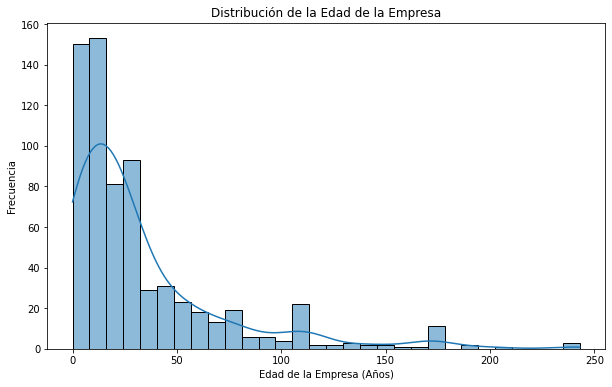

In [0]:
# Visualización de la distribución de la antigüedad de la empresa (company_age)
plt.figure(figsize=(10, 6))
sns.histplot(df_filled.toPandas()["company_age"], bins=30, kde=True)
plt.title("Distribución de la Edad de la Empresa")
plt.xlabel("Edad de la Empresa (Años)")
plt.ylabel("Frecuencia")
plt.show()


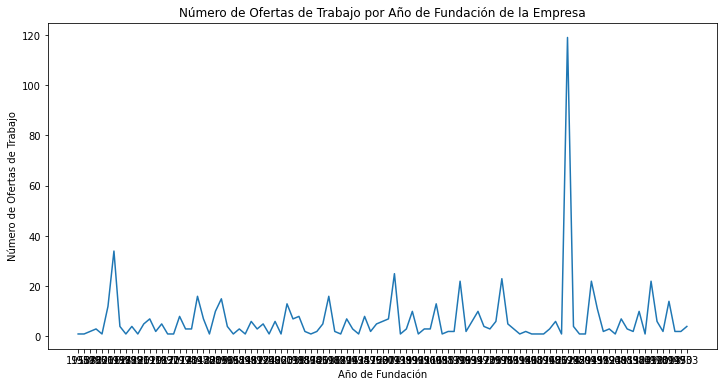

In [0]:
# Agrupar por 'Founded' y contar el número de ofertas
df_founded_counts = df_filled.groupBy("Founded").count()

# Convertir a Pandas para la visualización
df_founded_counts_pd = df_founded_counts.toPandas()

# Visualización con Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x="Founded", y="count", data=df_founded_counts_pd)
plt.title("Número de Ofertas de Trabajo por Año de Fundación de la Empresa")
plt.xlabel("Año de Fundación")
plt.ylabel("Número de Ofertas de Trabajo")
plt.show()


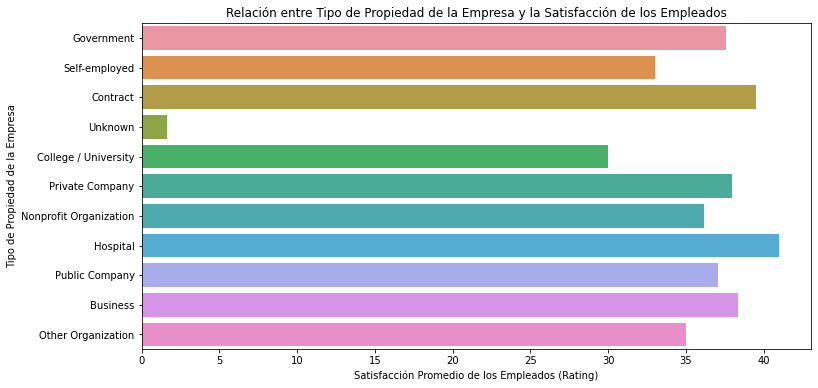

In [0]:
# Agrupar por 'Type of ownership' y calcular la media de la satisfacción (Rating)
df_ownership_rating = df_filled.groupBy("Type of ownership").agg(F.avg("Rating").alias("avg_rating"))

# Convertir a Pandas para la visualización
df_ownership_rating_pd = df_ownership_rating.toPandas()

# Visualización con Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x="avg_rating", y="Type of ownership", data=df_ownership_rating_pd)
plt.title("Relación entre Tipo de Propiedad de la Empresa y la Satisfacción de los Empleados")
plt.xlabel("Satisfacción Promedio de los Empleados (Rating)")
plt.ylabel("Tipo de Propiedad de la Empresa")
plt.show()


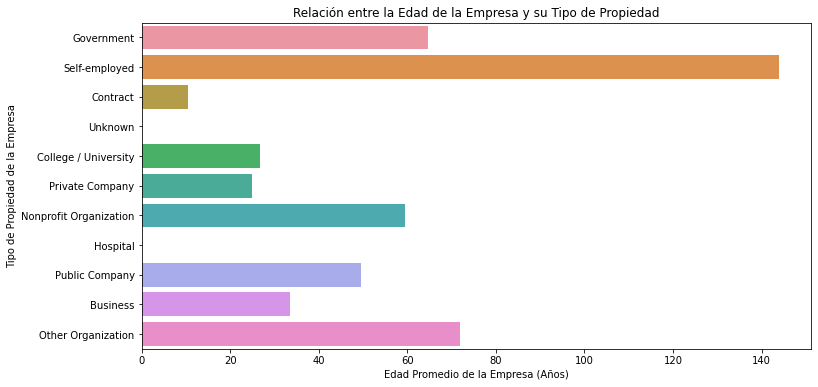

In [0]:
# Agrupar por 'Type of ownership' y calcular la edad promedio de la empresa
df_ownership_age = df_filled.groupBy("Type of ownership").agg(F.avg("company_age").alias("avg_company_age"))

# Convertir a Pandas para la visualización
df_ownership_age_pd = df_ownership_age.toPandas()

# Visualización con Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x="avg_company_age", y="Type of ownership", data=df_ownership_age_pd)
plt.title("Relación entre la Edad de la Empresa y su Tipo de Propiedad")
plt.xlabel("Edad Promedio de la Empresa (Años)")
plt.ylabel("Tipo de Propiedad de la Empresa")
plt.show()
